# Transition State Search (NEBs)

FAIR chemistry models can be used to enumerate and study reaction pathways via transition state search tools built into ASE or in packages like Sella via the ASE interface.

The first section of this tutorial walks through how to use the CatTsunami tools to automatically enumerate a number of hypothetical initial/final configurations for various types of reactions on a heterogeneous catalyst surface. If you already have a NEB you're looking to optimize, you can jump straight to the last section (Run NEBs)!

Since the NEB calculations here can be a bit time consuming, we'll use a small number of steps during the documentation testing, and otherwise use a reasonable guess.

In [1]:
import os

# Use a small number of steps here to keep the docs fast during CI, but otherwise do quite reasonable settings.
fast_docs = os.environ.get("FAST_DOCS", "false").lower() == "true"
if fast_docs:
    optimization_steps = 20
else:
    optimization_steps = 300

````{admonition} Need to install fairchem-core or get UMA access or getting permissions/401 errors?
:class: dropdown


1. Install the necessary packages using pip, uv etc
```{code-cell} ipython3
:tags: [skip-execution]

! pip install fairchem-core fairchem-data-oc fairchem-applications-cattsunami
```

2. Get access to any necessary huggingface gated models
    * Get and login to your Huggingface account
    * Request access to https://huggingface.co/facebook/UMA
    * Create a Huggingface token at https://huggingface.co/settings/tokens/ with the permission "Permissions: Read access to contents of all public gated repos you can access"
    * Add the token as an environment variable using `huggingface-cli login` or by setting the HF_TOKEN environment variable.

```{code-cell} ipython3
:tags: [skip-execution]

# Login using the huggingface-cli utility
! huggingface-cli login

# alternatively,
import os
os.environ['HF_TOKEN'] = 'MY_TOKEN'
```

````

## Do enumerations in an AdsorbML style

In [2]:
from __future__ import annotations

import matplotlib.pyplot as plt
from ase.io import read
from ase.mep import DyNEB
from ase.optimize import BFGS
from fairchem.applications.cattsunami.core import Reaction
from fairchem.applications.cattsunami.core.autoframe import AutoFrameDissociation
from fairchem.applications.cattsunami.databases import DISSOCIATION_REACTION_DB_PATH
from fairchem.core import FAIRChemCalculator, pretrained_mlip
from fairchem.data.oc.core import Adsorbate, AdsorbateSlabConfig, Bulk, Slab
from fairchem.data.oc.databases.pkls import ADSORBATE_PKL_PATH, BULK_PKL_PATH
from x3dase.x3d import X3D

# Instantiate the reaction class for the reaction of interest
reaction = Reaction(
    reaction_str_from_db="*CH -> *C + *H",
    reaction_db_path=DISSOCIATION_REACTION_DB_PATH,
    adsorbate_db_path=ADSORBATE_PKL_PATH,
)

In [3]:
# Instantiate our adsorbate class for the reactant and product
reactant = Adsorbate(
    adsorbate_id_from_db=reaction.reactant1_idx, adsorbate_db_path=ADSORBATE_PKL_PATH
)
product1 = Adsorbate(
    adsorbate_id_from_db=reaction.product1_idx, adsorbate_db_path=ADSORBATE_PKL_PATH
)
product2 = Adsorbate(
    adsorbate_id_from_db=reaction.product2_idx, adsorbate_db_path=ADSORBATE_PKL_PATH
)

In [4]:
# Grab the bulk and cut the slab we are interested in
bulk = Bulk(bulk_src_id_from_db="mp-33", bulk_db_path=BULK_PKL_PATH)
slab = Slab.from_bulk_get_specific_millers(bulk=bulk, specific_millers=(0, 0, 1))

In [5]:
# Perform site enumeration
# For AdsorbML num_sites = 100, but we use 5 here for brevity. This should be increased for practical use.
reactant_configs = AdsorbateSlabConfig(
    slab=slab[0],
    adsorbate=reactant,
    mode="random_site_heuristic_placement",
    num_sites=10,
).atoms_list
product1_configs = AdsorbateSlabConfig(
    slab=slab[0],
    adsorbate=product1,
    mode="random_site_heuristic_placement",
    num_sites=10,
).atoms_list
product2_configs = AdsorbateSlabConfig(
    slab=slab[0],
    adsorbate=product2,
    mode="random_site_heuristic_placement",
    num_sites=10,
).atoms_list

In [6]:
# Instantiate the calculator
predictor = pretrained_mlip.get_predict_unit("uma-s-1p1")
calc = FAIRChemCalculator(predictor, task_name="oc20")

In [7]:
# Relax the reactant systems
reactant_energies = []
for config in reactant_configs:
    config.calc = calc
    config.pbc = True
    opt = BFGS(config)
    opt.run(fmax=0.05, steps=optimization_steps)
    reactant_energies.append(config.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 22:42:14     -300.885256        4.036973


BFGS:    1 22:42:14     -301.278400        3.438302


BFGS:    2 22:42:14     -302.422891        3.423166


BFGS:    3 22:42:14     -302.192101        8.717020


BFGS:    4 22:42:14     -302.727058        2.856669


BFGS:    5 22:42:14     -302.878867        1.989686


BFGS:    6 22:42:14     -303.013329        2.152452


BFGS:    7 22:42:15     -303.059602        0.827330


BFGS:    8 22:42:15     -303.098738        0.732579


BFGS:    9 22:42:15     -303.158770        1.435822


BFGS:   10 22:42:15     -303.177582        0.877205


BFGS:   11 22:42:15     -303.192659        0.132653


BFGS:   12 22:42:15     -303.194067        0.137350


BFGS:   13 22:42:15     -303.195758        0.114233


BFGS:   14 22:42:15     -303.197530        0.079238


BFGS:   15 22:42:15     -303.198725        0.087037


BFGS:   16 22:42:15     -303.199236        0.073548


BFGS:   17 22:42:15     -303.199489        0.058366


BFGS:   18 22:42:15     -303.199936        0.053759


BFGS:   19 22:42:16     -303.200661        0.080606


BFGS:   20 22:42:16     -303.201531        0.086642


BFGS:   21 22:42:16     -303.202158        0.082135


BFGS:   22 22:42:16     -303.202606        0.083173


BFGS:   23 22:42:16     -303.203194        0.084205


BFGS:   24 22:42:16     -303.204658        0.113635


BFGS:   25 22:42:16     -303.209453        0.215496


BFGS:   26 22:42:16     -303.222780        0.517843


BFGS:   27 22:42:16     -303.240453        0.977038


BFGS:   28 22:42:16     -303.249747        1.459819


BFGS:   29 22:42:16     -303.229457        1.339162


BFGS:   30 22:42:17     -303.258091        1.521025


BFGS:   31 22:42:17     -303.262596        1.356936


BFGS:   32 22:42:17     -303.269259        1.371653


BFGS:   33 22:42:17     -303.274762        1.406020


BFGS:   34 22:42:17     -303.283442        1.456196


BFGS:   35 22:42:17     -303.290140        1.599722


BFGS:   36 22:42:17     -303.297091        1.756895


BFGS:   37 22:42:17     -303.302714        1.820198


BFGS:   38 22:42:17     -303.309734        1.811059


BFGS:   39 22:42:17     -303.321396        1.910011


BFGS:   40 22:42:17     -303.336828        1.726181


BFGS:   41 22:42:17     -303.355924        2.073526


BFGS:   42 22:42:18     -303.379599        2.024704


BFGS:   43 22:42:18     -303.411508        2.167642


BFGS:   44 22:42:18     -303.438662        2.135357


BFGS:   45 22:42:18     -303.475837        2.114299


BFGS:   46 22:42:18     -303.504986        1.926419


BFGS:   47 22:42:18     -303.536687        1.928545


BFGS:   48 22:42:18     -303.587396        1.776232


BFGS:   49 22:42:18     -303.646430        1.558411


BFGS:   50 22:42:18     -303.728529        1.339313


BFGS:   51 22:42:18     -303.804896        1.178846


BFGS:   52 22:42:18     -303.876872        0.954810


BFGS:   53 22:42:19     -303.943462        0.974421


BFGS:   54 22:42:19     -304.006969        1.036047


BFGS:   55 22:42:19     -304.067636        1.051468


BFGS:   56 22:42:19     -304.124118        0.847120


BFGS:   57 22:42:19     -304.175522        0.805376


BFGS:   58 22:42:19     -304.232233        0.599079


BFGS:   59 22:42:19     -304.285412        0.416916


BFGS:   60 22:42:19     -304.322475        0.340155


BFGS:   61 22:42:19     -304.329738        0.453742


BFGS:   62 22:42:19     -304.337026        0.275381


BFGS:   63 22:42:19     -304.342799        0.219445


BFGS:   64 22:42:19     -304.350808        0.111118


BFGS:   65 22:42:20     -304.353231        0.078490


BFGS:   66 22:42:20     -304.354503        0.068033


BFGS:   67 22:42:20     -304.355143        0.060461


BFGS:   68 22:42:20     -304.355751        0.050231


BFGS:   69 22:42:20     -304.356177        0.037671


      Step     Time          Energy          fmax
BFGS:    0 22:42:20     -301.505836        4.084397


BFGS:    1 22:42:20     -301.886154        3.432745


BFGS:    2 22:42:20     -302.895263        3.215040


BFGS:    3 22:42:20     -302.992779        4.799333


BFGS:    4 22:42:21     -303.291080        2.373720


BFGS:    5 22:42:21     -303.513247        1.935754


BFGS:    6 22:42:21     -303.651546        2.665568


BFGS:    7 22:42:21     -303.950261        1.950190


BFGS:    8 22:42:21     -303.947137        1.800027


BFGS:    9 22:42:21     -304.078883        0.945941


BFGS:   10 22:42:21     -304.124239        0.850947


BFGS:   11 22:42:21     -304.214349        0.579619


BFGS:   12 22:42:21     -304.228225        0.439917


BFGS:   13 22:42:21     -304.253125        0.361522


BFGS:   14 22:42:21     -304.262085        0.387597


BFGS:   15 22:42:22     -304.276483        0.406755


BFGS:   16 22:42:22     -304.287884        0.354793


BFGS:   17 22:42:22     -304.298062        0.243284


BFGS:   18 22:42:22     -304.305317        0.267413


BFGS:   19 22:42:22     -304.313424        0.338140


BFGS:   20 22:42:22     -304.322736        0.357463


BFGS:   21 22:42:22     -304.330354        0.274508


BFGS:   22 22:42:22     -304.334203        0.202297


BFGS:   23 22:42:22     -304.337403        0.221387


BFGS:   24 22:42:22     -304.341162        0.231041


BFGS:   25 22:42:22     -304.344848        0.228097


BFGS:   26 22:42:23     -304.348877        0.250398


BFGS:   27 22:42:23     -304.352248        0.169744


BFGS:   28 22:42:23     -304.353850        0.092499


BFGS:   29 22:42:23     -304.354747        0.099510


BFGS:   30 22:42:23     -304.355360        0.086490


BFGS:   31 22:42:23     -304.355993        0.066398


BFGS:   32 22:42:23     -304.356588        0.057078


BFGS:   33 22:42:23     -304.356874        0.029686


      Step     Time          Energy          fmax
BFGS:    0 22:42:23     -300.688645        4.024666


BFGS:    1 22:42:23     -301.137687        3.753506


BFGS:    2 22:42:23     -302.503727        3.693567


BFGS:    3 22:42:23     -302.330977        8.645473


BFGS:    4 22:42:24     -302.812412        3.158830


BFGS:    5 22:42:24     -302.992231        2.166274


BFGS:    6 22:42:24     -303.097790        2.298605


BFGS:    7 22:42:24     -303.132855        0.601973


BFGS:    8 22:42:24     -303.141908        0.425896


BFGS:    9 22:42:24     -303.158218        0.626385


BFGS:   10 22:42:24     -303.169190        0.580642


BFGS:   11 22:42:24     -303.175420        0.288542


BFGS:   12 22:42:24     -303.176782        0.158436


BFGS:   13 22:42:24     -303.178516        0.248812


BFGS:   14 22:42:24     -303.180940        0.336923


BFGS:   15 22:42:25     -303.184076        0.331812


BFGS:   16 22:42:25     -303.186606        0.203346


BFGS:   17 22:42:25     -303.187837        0.122898


BFGS:   18 22:42:25     -303.188384        0.154016


BFGS:   19 22:42:25     -303.189162        0.189537


BFGS:   20 22:42:25     -303.190197        0.176703


BFGS:   21 22:42:25     -303.190878        0.092120


BFGS:   22 22:42:25     -303.191075        0.022715


      Step     Time          Energy          fmax
BFGS:    0 22:42:25     -301.998776        4.140970


BFGS:    1 22:42:25     -302.382199        3.181895


BFGS:    2 22:42:25     -303.299114        3.242164


BFGS:    3 22:42:25     -303.466303        3.013382


BFGS:    4 22:42:26     -303.756238        2.006788


BFGS:    5 22:42:26     -303.891471        2.546779


BFGS:    6 22:42:26     -303.977140        1.682759


BFGS:    7 22:42:26     -304.168831        1.365290


BFGS:    8 22:42:26     -304.223648        1.167593


BFGS:    9 22:42:26     -304.428656        1.712277


BFGS:   10 22:42:26     -304.524709        1.207478


BFGS:   11 22:42:26     -304.602925        0.703094


BFGS:   12 22:42:26     -304.613830        0.438965


BFGS:   13 22:42:26     -304.624661        0.309895


BFGS:   14 22:42:26     -304.638807        0.317612


BFGS:   15 22:42:27     -304.650806        0.216148


BFGS:   16 22:42:27     -304.654592        0.224398


BFGS:   17 22:42:27     -304.657902        0.225072


BFGS:   18 22:42:27     -304.665220        0.213968


BFGS:   19 22:42:27     -304.673778        0.244402


BFGS:   20 22:42:27     -304.680851        0.229276


BFGS:   21 22:42:27     -304.684637        0.151400


BFGS:   22 22:42:27     -304.686160        0.104201


BFGS:   23 22:42:27     -304.687159        0.092396


BFGS:   24 22:42:27     -304.688595        0.096873


BFGS:   25 22:42:27     -304.690227        0.092106


BFGS:   26 22:42:27     -304.691298        0.059389


BFGS:   27 22:42:28     -304.691702        0.050654


BFGS:   28 22:42:28     -304.691863        0.047832


      Step     Time          Energy          fmax
BFGS:    0 22:42:28     -301.000238        4.002768


BFGS:    1 22:42:28     -301.401124        3.203538


BFGS:    2 22:42:28     -302.557240        3.667701


BFGS:    3 22:42:28     -302.625670        5.260755


BFGS:    4 22:42:28     -302.955832        2.448966


BFGS:    5 22:42:28     -303.060210        2.546871


BFGS:    6 22:42:28     -303.105003        0.533953


BFGS:    7 22:42:28     -303.119513        0.441859


BFGS:    8 22:42:28     -303.186059        0.699411


BFGS:    9 22:42:29     -303.198933        0.422098


BFGS:   10 22:42:29     -303.203696        0.243714


BFGS:   11 22:42:29     -303.209656        0.304687


BFGS:   12 22:42:29     -303.216928        0.394412


BFGS:   13 22:42:29     -303.223927        0.396049


BFGS:   14 22:42:29     -303.229734        0.353165


BFGS:   15 22:42:29     -303.234050        0.336025


BFGS:   16 22:42:29     -303.246956        0.600784


BFGS:   17 22:42:29     -303.330199        1.498138


BFGS:   18 22:42:29     -303.582781        1.811356


BFGS:   19 22:42:29     -303.915062        1.768237


BFGS:   20 22:42:30     -304.019978        2.461518


BFGS:   21 22:42:30     -304.148607        1.660902


BFGS:   22 22:42:30     -304.220127        1.168722


BFGS:   23 22:42:30     -304.303100        0.872147


BFGS:   24 22:42:30     -304.395845        0.991417


BFGS:   25 22:42:30     -304.459866        0.718067


BFGS:   26 22:42:30     -304.501824        0.548538


BFGS:   27 22:42:30     -304.519612        0.480174


BFGS:   28 22:42:30     -304.547621        0.506929


BFGS:   29 22:42:30     -304.574133        0.512707


BFGS:   30 22:42:30     -304.593752        0.415936


BFGS:   31 22:42:30     -304.608478        0.366466


BFGS:   32 22:42:31     -304.624544        0.401096


BFGS:   33 22:42:31     -304.641834        0.388413


BFGS:   34 22:42:31     -304.659483        0.255541


BFGS:   35 22:42:31     -304.669558        0.248453


BFGS:   36 22:42:31     -304.675112        0.225837


BFGS:   37 22:42:31     -304.679597        0.187751


BFGS:   38 22:42:31     -304.684136        0.129002


BFGS:   39 22:42:31     -304.687322        0.076305


BFGS:   40 22:42:31     -304.689118        0.083318


BFGS:   41 22:42:31     -304.689945        0.073564


BFGS:   42 22:42:31     -304.690390        0.085381


BFGS:   43 22:42:32     -304.690928        0.087287


BFGS:   44 22:42:32     -304.691530        0.062960


BFGS:   45 22:42:32     -304.691990        0.036207


      Step     Time          Energy          fmax
BFGS:    0 22:42:32     -300.982492        4.034743


BFGS:    1 22:42:32     -301.384154        3.161276


BFGS:    2 22:42:32     -302.539693        3.627417


BFGS:    3 22:42:32     -302.556663        6.022340


BFGS:    4 22:42:32     -302.904712        2.677244


BFGS:    5 22:42:32     -303.069200        1.354959


BFGS:    6 22:42:32     -303.096220        0.969314


BFGS:    7 22:42:32     -303.130888        1.012486


BFGS:    8 22:42:32     -303.153120        1.063757


BFGS:    9 22:42:33     -303.201773        0.524074


BFGS:   10 22:42:33     -303.207015        0.209034


BFGS:   11 22:42:33     -303.210421        0.265979


BFGS:   12 22:42:33     -303.217763        0.429459


BFGS:   13 22:42:33     -303.223457        0.417868


BFGS:   14 22:42:33     -303.228679        0.341407


BFGS:   15 22:42:33     -303.232414        0.313526


BFGS:   16 22:42:33     -303.241325        0.540654


BFGS:   17 22:42:33     -303.274543        1.175158


BFGS:   18 22:42:33     -303.369714        1.201914


BFGS:   19 22:42:33     -303.575726        1.911020


BFGS:   20 22:42:34     -303.635979        3.574935


BFGS:   21 22:42:34     -303.737140        2.795809


BFGS:   22 22:42:34     -303.856846        2.313143


BFGS:   23 22:42:34     -304.038467        1.638056


BFGS:   24 22:42:34     -304.138121        1.004696


BFGS:   25 22:42:34     -304.219342        0.863224


BFGS:   26 22:42:34     -304.248342        0.888670


BFGS:   27 22:42:34     -304.336791        1.035849


BFGS:   28 22:42:34     -304.347760        1.656096


BFGS:   29 22:42:34     -304.437801        0.936482


BFGS:   30 22:42:34     -304.473894        0.812914


BFGS:   31 22:42:34     -304.500945        1.057591


BFGS:   32 22:42:35     -304.539890        0.436026


BFGS:   33 22:42:35     -304.553695        0.356484


BFGS:   34 22:42:35     -304.591742        0.532729


BFGS:   35 22:42:35     -304.605351        0.495433


BFGS:   36 22:42:35     -304.622069        0.354916


BFGS:   37 22:42:35     -304.630713        0.349236


BFGS:   38 22:42:35     -304.644406        0.568240


BFGS:   39 22:42:35     -304.661747        0.625719


BFGS:   40 22:42:35     -304.676312        0.370886


BFGS:   41 22:42:35     -304.681670        0.146342


BFGS:   42 22:42:35     -304.683952        0.114315


BFGS:   43 22:42:36     -304.685627        0.094757


BFGS:   44 22:42:36     -304.687590        0.136026


BFGS:   45 22:42:36     -304.689549        0.122214


BFGS:   46 22:42:36     -304.690647        0.064302


BFGS:   47 22:42:36     -304.691105        0.045764


      Step     Time          Energy          fmax
BFGS:    0 22:42:36     -301.502950        4.070814


BFGS:    1 22:42:36     -301.887739        3.388053


BFGS:    2 22:42:36     -302.915958        3.258788


BFGS:    3 22:42:36     -303.019914        4.835571


BFGS:    4 22:42:36     -303.321755        2.389113


BFGS:    5 22:42:36     -303.546981        2.013786


BFGS:    6 22:42:37     -303.675268        2.612256


BFGS:    7 22:42:37     -303.974129        1.929707


BFGS:    8 22:42:37     -304.075612        1.149333


BFGS:    9 22:42:37     -304.147357        1.023374


BFGS:   10 22:42:37     -304.231954        0.837704


BFGS:   11 22:42:37     -304.286753        0.681960


BFGS:   12 22:42:37     -304.304211        0.504532


BFGS:   13 22:42:37     -304.317639        0.243457


BFGS:   14 22:42:37     -304.327989        0.194779


BFGS:   15 22:42:37     -304.333369        0.198688


BFGS:   16 22:42:37     -304.337100        0.189157


BFGS:   17 22:42:37     -304.339992        0.163713


BFGS:   18 22:42:38     -304.341798        0.144589


BFGS:   19 22:42:38     -304.343362        0.133629


BFGS:   20 22:42:38     -304.345348        0.198580


BFGS:   21 22:42:38     -304.348302        0.259557


BFGS:   22 22:42:38     -304.351873        0.248922


BFGS:   23 22:42:38     -304.354344        0.162431


BFGS:   24 22:42:38     -304.355629        0.079898


BFGS:   25 22:42:38     -304.356086        0.071606


BFGS:   26 22:42:38     -304.356337        0.056523


BFGS:   27 22:42:38     -304.356710        0.038735


      Step     Time          Energy          fmax
BFGS:    0 22:42:38     -301.131141        4.088279


BFGS:    1 22:42:39     -301.519628        3.289951


BFGS:    2 22:42:39     -302.592720        3.475675


BFGS:    3 22:42:39     -302.611321        5.662992


BFGS:    4 22:42:39     -302.936302        2.652932


BFGS:    5 22:42:39     -303.099855        1.024673


BFGS:    6 22:42:39     -303.145452        1.383566


BFGS:    7 22:42:39     -303.191002        0.979912


BFGS:    8 22:42:39     -303.248068        1.454271


BFGS:    9 22:42:39     -303.321292        1.268628


BFGS:   10 22:42:39     -303.363527        0.926419


BFGS:   11 22:42:39     -303.439383        1.028225


BFGS:   12 22:42:39     -303.577769        2.100260


BFGS:   13 22:42:40     -303.662283        3.220157


BFGS:   14 22:42:40     -303.801470        2.352692


BFGS:   15 22:42:40     -303.909457        1.488751


BFGS:   16 22:42:40     -304.020334        1.247991


BFGS:   17 22:42:40     -304.049536        0.987151


BFGS:   18 22:42:40     -304.079925        0.662554


BFGS:   19 22:42:40     -304.135251        0.331838


BFGS:   20 22:42:40     -304.144822        0.379882


BFGS:   21 22:42:40     -304.158174        0.454151


BFGS:   22 22:42:40     -304.173261        0.456352


BFGS:   23 22:42:40     -304.189331        0.348942


BFGS:   24 22:42:41     -304.201344        0.310919


BFGS:   25 22:42:41     -304.209694        0.419121


BFGS:   26 22:42:41     -304.222074        0.513241


BFGS:   27 22:42:41     -304.243136        0.505231


BFGS:   28 22:42:41     -304.255266        0.272139


BFGS:   29 22:42:41     -304.264629        0.279298


BFGS:   30 22:42:41     -304.271151        0.330231


BFGS:   31 22:42:41     -304.278819        0.398497


BFGS:   32 22:42:41     -304.288786        0.354015


BFGS:   33 22:42:41     -304.310179        0.287710


BFGS:   34 22:42:41     -304.320141        0.246981


BFGS:   35 22:42:42     -304.327378        0.222729


BFGS:   36 22:42:42     -304.331961        0.233894


BFGS:   37 22:42:42     -304.338863        0.174324


BFGS:   38 22:42:42     -304.344450        0.175423


BFGS:   39 22:42:42     -304.348725        0.148988


BFGS:   40 22:42:42     -304.351076        0.106175


BFGS:   41 22:42:42     -304.352254        0.093417


BFGS:   42 22:42:42     -304.353245        0.070285


BFGS:   43 22:42:42     -304.354450        0.095061


BFGS:   44 22:42:42     -304.355549        0.086613


BFGS:   45 22:42:42     -304.356170        0.057024


BFGS:   46 22:42:42     -304.356476        0.037629


      Step     Time          Energy          fmax
BFGS:    0 22:42:43     -301.490370        4.090055


BFGS:    1 22:42:43     -301.865652        3.118333


BFGS:    2 22:42:43     -302.823427        3.445878


BFGS:    3 22:42:43     -302.971799        3.296902


BFGS:    4 22:42:43     -303.254107        2.027275


BFGS:    5 22:42:43     -303.391695        3.466228


BFGS:    6 22:42:43     -303.501175        1.987173


BFGS:    7 22:42:43     -303.757398        1.174907


BFGS:    8 22:42:43     -304.109331        2.209693


BFGS:    9 22:42:43     -304.229886        2.689340


BFGS:   10 22:42:43     -304.340448        2.159875


BFGS:   11 22:42:44     -304.545279        1.164454


BFGS:   12 22:42:44     -304.595307        0.780749


BFGS:   13 22:42:44     -304.620261        0.485047


BFGS:   14 22:42:44     -304.633152        0.399195


BFGS:   15 22:42:44     -304.647851        0.238585


BFGS:   16 22:42:44     -304.652552        0.209403


BFGS:   17 22:42:44     -304.658833        0.213742


BFGS:   18 22:42:44     -304.664866        0.197991


BFGS:   19 22:42:44     -304.669760        0.190742


BFGS:   20 22:42:44     -304.673041        0.189063


BFGS:   21 22:42:44     -304.676284        0.158325


BFGS:   22 22:42:44     -304.680031        0.151376


BFGS:   23 22:42:45     -304.683954        0.174282


BFGS:   24 22:42:45     -304.686814        0.128566


BFGS:   25 22:42:45     -304.688320        0.108538


BFGS:   26 22:42:45     -304.689167        0.090147


BFGS:   27 22:42:45     -304.689879        0.069207


BFGS:   28 22:42:45     -304.690688        0.090927


BFGS:   29 22:42:45     -304.691395        0.077808


BFGS:   30 22:42:45     -304.691781        0.044543


      Step     Time          Energy          fmax
BFGS:    0 22:42:45     -301.920035        4.088148


BFGS:    1 22:42:45     -302.297502        2.916490


BFGS:    2 22:42:45     -303.220192        3.453780


BFGS:    3 22:42:46     -303.399660        3.190571


BFGS:    4 22:42:46     -303.770249        2.000802


BFGS:    5 22:42:46     -303.856931        1.803981


BFGS:    6 22:42:46     -303.942701        1.613535


BFGS:    7 22:42:46     -304.039883        0.904978


BFGS:    8 22:42:46     -304.065518        0.691627


BFGS:    9 22:42:46     -304.131206        0.698925


BFGS:   10 22:42:46     -304.168210        0.394222


BFGS:   11 22:42:46     -304.178118        0.248918


BFGS:   12 22:42:46     -304.183547        0.257183


BFGS:   13 22:42:46     -304.190844        0.299555


BFGS:   14 22:42:46     -304.200298        0.278491


BFGS:   15 22:42:47     -304.206100        0.274036


BFGS:   16 22:42:47     -304.210611        0.257185


BFGS:   17 22:42:47     -304.217674        0.306200


BFGS:   18 22:42:47     -304.230067        0.568678


BFGS:   19 22:42:47     -304.244658        0.871691


BFGS:   20 22:42:47     -304.262050        0.545291


BFGS:   21 22:42:47     -304.278485        0.314096


BFGS:   22 22:42:47     -304.283237        0.363780


BFGS:   23 22:42:47     -304.290237        0.347688


BFGS:   24 22:42:47     -304.304625        0.303429


BFGS:   25 22:42:48     -304.318414        0.273770


BFGS:   26 22:42:48     -304.327080        0.249763


BFGS:   27 22:42:48     -304.331842        0.213415


BFGS:   28 22:42:48     -304.335961        0.177677


BFGS:   29 22:42:48     -304.342718        0.201397


BFGS:   30 22:42:48     -304.349125        0.168393


BFGS:   31 22:42:48     -304.352612        0.099123


BFGS:   32 22:42:48     -304.353796        0.076447


BFGS:   33 22:42:48     -304.354551        0.079986


BFGS:   34 22:42:48     -304.355193        0.081576


BFGS:   35 22:42:49     -304.355873        0.059017


BFGS:   36 22:42:49     -304.356366        0.042165


In [8]:
# Relax the product systems
product1_energies = []
for config in product1_configs:
    config.calc = calc
    config.pbc = True
    opt = BFGS(config)
    opt.run(fmax=0.05, steps=optimization_steps)
    product1_energies.append(config.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 22:42:49     -296.499385        4.449457


BFGS:    1 22:42:49     -296.974153        4.674884


BFGS:    2 22:42:49     -298.364071        3.406785


BFGS:    3 22:42:49     -298.098416        8.772037


BFGS:    4 22:42:49     -298.655977        1.917779


BFGS:    5 22:42:49     -298.734331        1.354764


BFGS:    6 22:42:49     -298.856668        1.869049


BFGS:    7 22:42:49     -298.973616        2.126500


BFGS:    8 22:42:49     -299.218742        2.127447


BFGS:    9 22:42:49     -299.424030        1.812626


BFGS:   10 22:42:50     -299.527787        1.507413


BFGS:   11 22:42:50     -299.622384        1.289225


BFGS:   12 22:42:50     -299.989028        1.023361


BFGS:   13 22:42:50     -300.007803        0.732582


BFGS:   14 22:42:50     -300.030901        0.532913


BFGS:   15 22:42:50     -300.041723        0.381649


BFGS:   16 22:42:50     -300.053479        0.323419


BFGS:   17 22:42:50     -300.061812        0.416784


BFGS:   18 22:42:50     -300.068135        0.407900


BFGS:   19 22:42:50     -300.073477        0.315080


BFGS:   20 22:42:50     -300.076447        0.199279


BFGS:   21 22:42:51     -300.077975        0.112645


BFGS:   22 22:42:51     -300.078839        0.088944


BFGS:   23 22:42:51     -300.079331        0.064833


BFGS:   24 22:42:51     -300.079909        0.071019


BFGS:   25 22:42:51     -300.080462        0.053826


BFGS:   26 22:42:51     -300.080710        0.022506


      Step     Time          Energy          fmax
BFGS:    0 22:42:51     -297.192316        4.733490


BFGS:    1 22:42:51     -297.669131        4.889116


BFGS:    2 22:42:51     -298.823653        4.198896


BFGS:    3 22:42:51     -299.464121        2.046880


BFGS:    4 22:42:51     -299.654872        2.773361


BFGS:    5 22:42:52     -300.043876        2.158989


BFGS:    6 22:42:52     -300.190234        1.619320


BFGS:    7 22:42:52     -300.316971        1.299581


BFGS:    8 22:42:52     -300.426261        1.525567


BFGS:    9 22:42:52     -300.505014        1.457799


BFGS:   10 22:42:52     -300.558023        0.773193


BFGS:   11 22:42:52     -300.587014        0.466753


BFGS:   12 22:42:52     -300.594121        0.385123


BFGS:   13 22:42:52     -300.603440        0.349502


BFGS:   14 22:42:52     -300.611369        0.295310


BFGS:   15 22:42:52     -300.616629        0.164677


BFGS:   16 22:42:52     -300.618896        0.151322


BFGS:   17 22:42:53     -300.620446        0.153235


BFGS:   18 22:42:53     -300.621751        0.119460


BFGS:   19 22:42:53     -300.623070        0.061170


BFGS:   20 22:42:53     -300.624097        0.035075


      Step     Time          Energy          fmax
BFGS:    0 22:42:53     -296.003675        4.354725


BFGS:    1 22:42:53     -296.532035        4.728174


BFGS:    2 22:42:53     -298.206787        3.042665


BFGS:    3 22:42:53     -296.794654       16.900455


BFGS:    4 22:42:53     -298.383441        1.863903


BFGS:    5 22:42:53     -298.445929        1.044773


BFGS:    6 22:42:53     -298.481229        0.592884


BFGS:    7 22:42:54     -298.485630        0.314092


BFGS:    8 22:42:54     -298.491169        0.134091


BFGS:    9 22:42:54     -298.493133        0.169161


BFGS:   10 22:42:54     -298.493886        0.136451


BFGS:   11 22:42:54     -298.494416        0.110752


BFGS:   12 22:42:54     -298.495695        0.137485


BFGS:   13 22:42:54     -298.499087        0.230347


BFGS:   14 22:42:54     -298.517247        0.569655


BFGS:   15 22:42:54     -298.509104        0.965163


BFGS:   16 22:42:54     -298.625884        0.805950


BFGS:   17 22:42:54     -298.690920        1.920485


BFGS:   18 22:42:54     -298.753461        2.127751


BFGS:   19 22:42:55     -298.858431        1.518897


BFGS:   20 22:42:55     -299.002780        1.940942


BFGS:   21 22:42:55     -299.225974        2.590730


BFGS:   22 22:42:55     -299.400002        2.496099


BFGS:   23 22:42:55     -299.590047        2.322212


BFGS:   24 22:42:55     -300.022182        1.716588


BFGS:   25 22:42:55     -300.188543        1.606715


BFGS:   26 22:42:55     -300.294338        1.451582


BFGS:   27 22:42:55     -300.443146        1.129853


BFGS:   28 22:42:55     -300.518738        0.716516


BFGS:   29 22:42:55     -300.574380        0.608448


BFGS:   30 22:42:56     -300.582665        0.331726


BFGS:   31 22:42:56     -300.594914        0.332600


BFGS:   32 22:42:56     -300.609140        0.264372


BFGS:   33 22:42:56     -300.615868        0.149158


BFGS:   34 22:42:56     -300.618351        0.118288


BFGS:   35 22:42:56     -300.619217        0.112084


BFGS:   36 22:42:56     -300.620762        0.109597


BFGS:   37 22:42:56     -300.622444        0.109396


BFGS:   38 22:42:56     -300.623976        0.091796


BFGS:   39 22:42:56     -300.624632        0.056700


BFGS:   40 22:42:56     -300.624812        0.029371


      Step     Time          Energy          fmax
BFGS:    0 22:42:57     -296.300203        4.411115


BFGS:    1 22:42:57     -296.787170        4.689755


BFGS:    2 22:42:57     -298.264735        3.301398


BFGS:    3 22:42:57     -297.680289       10.998199


BFGS:    4 22:42:57     -298.506540        1.892721


BFGS:    5 22:42:57     -298.575987        1.143047


BFGS:    6 22:42:57     -298.634387        1.211851


BFGS:    7 22:42:57     -298.661967        1.185280


BFGS:    8 22:42:57     -298.803751        1.208300


BFGS:    9 22:42:57     -298.870582        1.561315


BFGS:   10 22:42:57     -299.011104        2.200969


BFGS:   11 22:42:57     -299.139826        2.487664


BFGS:   12 22:42:58     -299.255923        2.635670


BFGS:   13 22:42:58     -299.470699        2.498204


BFGS:   14 22:42:58     -299.901832        1.487684


BFGS:   15 22:42:58     -299.936717        1.259489


BFGS:   16 22:42:58     -299.993123        0.970347


BFGS:   17 22:42:58     -300.039981        0.348232


BFGS:   18 22:42:58     -300.056664        0.222405


BFGS:   19 22:42:58     -300.064096        0.233318


BFGS:   20 22:42:58     -300.069509        0.222004


BFGS:   21 22:42:58     -300.073388        0.173026


BFGS:   22 22:42:58     -300.075949        0.097590


BFGS:   23 22:42:59     -300.077024        0.081417


BFGS:   24 22:42:59     -300.077501        0.075793


BFGS:   25 22:42:59     -300.078090        0.065232


BFGS:   26 22:42:59     -300.078945        0.080876


BFGS:   27 22:42:59     -300.079774        0.073431


BFGS:   28 22:42:59     -300.080231        0.051069


BFGS:   29 22:42:59     -300.080417        0.050463


BFGS:   30 22:42:59     -300.080534        0.040629


      Step     Time          Energy          fmax
BFGS:    0 22:42:59     -297.306456        4.771646


BFGS:    1 22:42:59     -297.794579        4.900629


BFGS:    2 22:42:59     -299.054237        3.825396


BFGS:    3 22:42:59     -299.463611        3.698697


BFGS:    4 22:43:00     -299.620167        1.772221


BFGS:    5 22:43:00     -299.810876        1.524538


BFGS:    6 22:43:00     -299.979397        1.398922


BFGS:    7 22:43:00     -300.039397        1.461349


BFGS:    8 22:43:00     -300.335420        1.397389


BFGS:    9 22:43:00     -300.420436        1.352913


BFGS:   10 22:43:00     -300.512122        0.924900


BFGS:   11 22:43:00     -300.545649        0.682843


BFGS:   12 22:43:00     -300.574625        0.445542


BFGS:   13 22:43:00     -300.590316        0.462699


BFGS:   14 22:43:00     -300.602592        0.342972


BFGS:   15 22:43:01     -300.608221        0.203770


BFGS:   16 22:43:01     -300.612839        0.250190


BFGS:   17 22:43:01     -300.616621        0.246099


BFGS:   18 22:43:01     -300.620024        0.182805


BFGS:   19 22:43:01     -300.622201        0.130656


BFGS:   20 22:43:01     -300.623107        0.089163


BFGS:   21 22:43:01     -300.623524        0.064537


BFGS:   22 22:43:01     -300.623988        0.078829


BFGS:   23 22:43:01     -300.624481        0.065655


BFGS:   24 22:43:01     -300.624774        0.038324


      Step     Time          Energy          fmax
BFGS:    0 22:43:01     -296.462343        4.434470


BFGS:    1 22:43:01     -296.929781        4.678212


BFGS:    2 22:43:02     -298.326444        3.494634


BFGS:    3 22:43:02     -298.134893        8.364893


BFGS:    4 22:43:02     -298.641043        1.940601


BFGS:    5 22:43:02     -298.722892        1.380939


BFGS:    6 22:43:02     -298.868843        2.184028


BFGS:    7 22:43:02     -299.058785        2.761238


BFGS:    8 22:43:02     -299.331022        2.856431


BFGS:    9 22:43:02     -299.520324        2.412220


BFGS:   10 22:43:02     -299.591788        1.874372


BFGS:   11 22:43:02     -299.730432        1.798203


BFGS:   12 22:43:02     -300.385924        1.247870


BFGS:   13 22:43:03     -300.452950        1.307709


BFGS:   14 22:43:03     -300.489388        1.353079


BFGS:   15 22:43:03     -300.570046        0.890675


BFGS:   16 22:43:03     -300.593007        0.564402


BFGS:   17 22:43:03     -300.603703        0.346190


BFGS:   18 22:43:03     -300.610385        0.201009


BFGS:   19 22:43:03     -300.615613        0.221675


BFGS:   20 22:43:03     -300.618918        0.208229


BFGS:   21 22:43:03     -300.620727        0.164729


BFGS:   22 22:43:03     -300.621825        0.109514


BFGS:   23 22:43:03     -300.622723        0.102467


BFGS:   24 22:43:03     -300.623556        0.092016


BFGS:   25 22:43:04     -300.624204        0.062458


BFGS:   26 22:43:04     -300.624559        0.045340


      Step     Time          Energy          fmax
BFGS:    0 22:43:04     -296.781846        4.480540


BFGS:    1 22:43:04     -297.248011        4.652190


BFGS:    2 22:43:04     -298.553998        3.517385


BFGS:    3 22:43:04     -298.591500        6.565120


BFGS:    4 22:43:04     -298.928501        1.933713


BFGS:    5 22:43:04     -299.025239        1.665001


BFGS:    6 22:43:04     -299.366590        2.005738


BFGS:    7 22:43:04     -299.649184        1.961318


BFGS:    8 22:43:04     -299.795937        1.215847


BFGS:    9 22:43:05     -299.875325        0.915571


BFGS:   10 22:43:05     -300.020165        0.821373


BFGS:   11 22:43:05     -300.033051        0.646930


BFGS:   12 22:43:05     -300.056654        0.256235


BFGS:   13 22:43:05     -300.060463        0.258403


BFGS:   14 22:43:05     -300.068491        0.263005


BFGS:   15 22:43:05     -300.074209        0.197722


BFGS:   16 22:43:05     -300.077110        0.122650


BFGS:   17 22:43:05     -300.078030        0.091782


BFGS:   18 22:43:05     -300.078554        0.087511


BFGS:   19 22:43:05     -300.079144        0.072281


BFGS:   20 22:43:06     -300.079854        0.049080


      Step     Time          Energy          fmax
BFGS:    0 22:43:06     -297.687532        4.513171


BFGS:    1 22:43:06     -298.160703        4.533018


BFGS:    2 22:43:06     -299.313751        3.011162


BFGS:    3 22:43:06     -299.460505        3.926848


BFGS:    4 22:43:06     -299.661138        1.292239


BFGS:    5 22:43:06     -299.749318        1.153889


BFGS:    6 22:43:06     -299.996566        0.603422


BFGS:    7 22:43:06     -300.017111        0.506843


BFGS:    8 22:43:06     -300.067964        0.367225


BFGS:    9 22:43:06     -300.075900        0.208454


BFGS:   10 22:43:06     -300.079002        0.085176


BFGS:   11 22:43:07     -300.079335        0.061155


BFGS:   12 22:43:07     -300.079741        0.059462


BFGS:   13 22:43:07     -300.080086        0.055122


BFGS:   14 22:43:07     -300.080256        0.043247


      Step     Time          Energy          fmax
BFGS:    0 22:43:07     -296.335916        4.421415


BFGS:    1 22:43:07     -296.820085        4.686840


BFGS:    2 22:43:07     -298.279844        3.352585


BFGS:    3 22:43:07     -297.798770       10.325850


BFGS:    4 22:43:07     -298.538294        1.910432


BFGS:    5 22:43:07     -298.610780        1.204341


BFGS:    6 22:43:07     -298.683020        1.422452


BFGS:    7 22:43:08     -298.728610        1.523479


BFGS:    8 22:43:08     -298.939160        1.563677


BFGS:    9 22:43:08     -299.086324        1.866161


BFGS:   10 22:43:08     -299.187748        1.832649


BFGS:   11 22:43:08     -299.361561        1.662239


BFGS:   12 22:43:08     -299.826444        1.240076


BFGS:   13 22:43:08     -299.854513        0.604301


BFGS:   14 22:43:08     -299.866066        0.647284


BFGS:   15 22:43:08     -299.883900        0.422239


BFGS:   16 22:43:08     -299.907405        0.380684


BFGS:   17 22:43:08     -299.915403        0.305253


BFGS:   18 22:43:08     -299.919956        0.236525


BFGS:   19 22:43:09     -299.924787        0.261046


BFGS:   20 22:43:09     -299.929594        0.346388


BFGS:   21 22:43:09     -299.934964        0.412355


BFGS:   22 22:43:09     -299.942927        0.450882


BFGS:   23 22:43:09     -299.955264        0.430006


BFGS:   24 22:43:09     -299.971636        0.471760


BFGS:   25 22:43:09     -299.989271        0.465794


BFGS:   26 22:43:09     -300.009967        0.559459


BFGS:   27 22:43:09     -300.032963        0.474827


BFGS:   28 22:43:09     -300.035711        0.703387


BFGS:   29 22:43:09     -300.060578        0.240841


BFGS:   30 22:43:10     -300.066424        0.187537


BFGS:   31 22:43:10     -300.073283        0.109914


BFGS:   32 22:43:10     -300.075216        0.126685


BFGS:   33 22:43:10     -300.077304        0.117584


BFGS:   34 22:43:10     -300.078818        0.083441


BFGS:   35 22:43:10     -300.079683        0.043711


      Step     Time          Energy          fmax
BFGS:    0 22:43:10     -296.632256        4.495458


BFGS:    1 22:43:10     -297.093134        4.712604


BFGS:    2 22:43:10     -298.429699        3.665272


BFGS:    3 22:43:10     -298.513533        6.469540


BFGS:    4 22:43:10     -298.832505        1.979717


BFGS:    5 22:43:10     -298.934004        1.722695


BFGS:    6 22:43:11     -299.330777        2.351045


BFGS:    7 22:43:11     -299.699331        2.714273


BFGS:    8 22:43:11     -299.961434        2.038922


BFGS:    9 22:43:11     -300.071464        1.670436


BFGS:   10 22:43:11     -300.244778        1.530663


BFGS:   11 22:43:11     -300.544433        0.867090


BFGS:   12 22:43:11     -300.562642        0.670425


BFGS:   13 22:43:11     -300.586931        0.372461


BFGS:   14 22:43:11     -300.603442        0.322591


BFGS:   15 22:43:11     -300.610127        0.283406


BFGS:   16 22:43:11     -300.614031        0.232249


BFGS:   17 22:43:12     -300.617361        0.156017


BFGS:   18 22:43:12     -300.619830        0.170758


BFGS:   19 22:43:12     -300.621041        0.172910


BFGS:   20 22:43:12     -300.622134        0.145849


BFGS:   21 22:43:12     -300.623161        0.089940


BFGS:   22 22:43:12     -300.623922        0.075678


BFGS:   23 22:43:12     -300.624363        0.069682


BFGS:   24 22:43:12     -300.624639        0.056755


BFGS:   25 22:43:12     -300.624859        0.044215


In [9]:
product2_energies = []
for config in product2_configs:
    config.calc = calc
    config.pbc = True
    opt = BFGS(config)
    opt.run(fmax=0.05, steps=optimization_steps)
    product2_energies.append(config.get_potential_energy())

      Step     Time          Energy          fmax
BFGS:    0 22:43:12     -295.312888        1.276168


BFGS:    1 22:43:12     -295.391530        1.164782


BFGS:    2 22:43:12     -295.600068        1.460538


BFGS:    3 22:43:13     -295.640067        0.566893


BFGS:    4 22:43:13     -295.650573        0.507122


BFGS:    5 22:43:13     -295.685539        0.463377


BFGS:    6 22:43:13     -295.691427        0.464914


BFGS:    7 22:43:13     -295.747174        0.768991


BFGS:    8 22:43:13     -295.763557        0.585624


BFGS:    9 22:43:13     -295.787385        0.698332


BFGS:   10 22:43:13     -295.805012        0.676235


BFGS:   11 22:43:13     -295.831029        0.438105


BFGS:   12 22:43:13     -295.838779        0.279644


BFGS:   13 22:43:13     -295.844356        0.230376


BFGS:   14 22:43:14     -295.846067        0.208573


BFGS:   15 22:43:14     -295.848858        0.186782


BFGS:   16 22:43:14     -295.851695        0.148554


BFGS:   17 22:43:14     -295.854273        0.127379


BFGS:   18 22:43:14     -295.855622        0.129087


BFGS:   19 22:43:14     -295.856455        0.137674


BFGS:   20 22:43:14     -295.857648        0.153830


BFGS:   21 22:43:14     -295.860317        0.186186


BFGS:   22 22:43:14     -295.865123        0.224203


BFGS:   23 22:43:14     -295.871760        0.252330


BFGS:   24 22:43:14     -295.880802        0.327046


BFGS:   25 22:43:14     -295.894980        0.450916


BFGS:   26 22:43:15     -295.915726        0.501966


BFGS:   27 22:43:15     -295.944326        0.333833


BFGS:   28 22:43:15     -295.951418        0.192316


BFGS:   29 22:43:15     -295.955868        0.171627


BFGS:   30 22:43:15     -295.961266        0.109955


BFGS:   31 22:43:15     -295.962908        0.095896


BFGS:   32 22:43:15     -295.964538        0.075233


BFGS:   33 22:43:15     -295.965973        0.063392


BFGS:   34 22:43:15     -295.967289        0.049461


      Step     Time          Energy          fmax
BFGS:    0 22:43:15     -295.434155        1.067804


BFGS:    1 22:43:15     -295.500415        0.985679


BFGS:    2 22:43:16     -295.709294        0.996262


BFGS:    3 22:43:16     -295.733331        0.527926


BFGS:    4 22:43:16     -295.743367        0.472407


BFGS:    5 22:43:16     -295.785192        0.530788


BFGS:    6 22:43:16     -295.793158        0.494513


BFGS:    7 22:43:16     -295.827656        0.375109


BFGS:    8 22:43:16     -295.838669        0.243336


BFGS:    9 22:43:16     -295.841892        0.228806


BFGS:   10 22:43:16     -295.846377        0.203068


BFGS:   11 22:43:16     -295.849323        0.183820


BFGS:   12 22:43:16     -295.853888        0.155199


BFGS:   13 22:43:17     -295.855753        0.146973


BFGS:   14 22:43:17     -295.856954        0.145602


BFGS:   15 22:43:17     -295.858648        0.148914


BFGS:   16 22:43:17     -295.861995        0.164042


BFGS:   17 22:43:17     -295.867366        0.199841


BFGS:   18 22:43:17     -295.873750        0.246710


BFGS:   19 22:43:17     -295.879740        0.318376


BFGS:   20 22:43:17     -295.886491        0.326008


BFGS:   21 22:43:17     -295.895983        0.296993


BFGS:   22 22:43:17     -295.909742        0.243127


BFGS:   23 22:43:17     -295.921700        0.228537


BFGS:   24 22:43:17     -295.927532        0.150887


BFGS:   25 22:43:18     -295.928282        0.128807


BFGS:   26 22:43:18     -295.930804        0.100334


BFGS:   27 22:43:18     -295.932525        0.075362


BFGS:   28 22:43:18     -295.934820        0.049454


      Step     Time          Energy          fmax
BFGS:    0 22:43:18     -295.564411        0.754227


BFGS:    1 22:43:18     -295.619773        0.671763


BFGS:    2 22:43:18     -295.803645        0.474329


BFGS:    3 22:43:18     -295.817650        0.300345


BFGS:    4 22:43:18     -295.821216        0.295937


BFGS:    5 22:43:18     -295.836668        0.233959


BFGS:    6 22:43:18     -295.838369        0.203479


BFGS:    7 22:43:19     -295.842568        0.146139


BFGS:    8 22:43:19     -295.843758        0.080245


BFGS:    9 22:43:19     -295.844263        0.075248


BFGS:   10 22:43:19     -295.844609        0.081097


BFGS:   11 22:43:19     -295.845231        0.086534


BFGS:   12 22:43:19     -295.845929        0.088454


BFGS:   13 22:43:19     -295.846559        0.090426


BFGS:   14 22:43:19     -295.847103        0.095971


BFGS:   15 22:43:19     -295.847943        0.130587


BFGS:   16 22:43:19     -295.850041        0.207927


BFGS:   17 22:43:19     -295.856421        0.405939


BFGS:   18 22:43:19     -295.861756        0.662405


BFGS:   19 22:43:20     -295.871686        0.514933


BFGS:   20 22:43:20     -295.903598        0.326347


BFGS:   21 22:43:20     -295.910206        0.232403


BFGS:   22 22:43:20     -295.915650        0.239312


BFGS:   23 22:43:20     -295.922815        0.168734


BFGS:   24 22:43:20     -295.929837        0.110867


BFGS:   25 22:43:20     -295.931259        0.101057


BFGS:   26 22:43:20     -295.932128        0.094919


BFGS:   27 22:43:20     -295.933401        0.092953


BFGS:   28 22:43:20     -295.934825        0.060665


BFGS:   29 22:43:20     -295.935682        0.049805


      Step     Time          Energy          fmax
BFGS:    0 22:43:21     -295.686865        0.718851


BFGS:    1 22:43:21     -295.736021        0.640443


BFGS:    2 22:43:21     -295.908003        0.384161


BFGS:    3 22:43:21     -295.920993        0.396307


BFGS:    4 22:43:21     -295.924115        0.382096


BFGS:    5 22:43:21     -295.953359        0.189610


BFGS:    6 22:43:21     -295.955688        0.182847


BFGS:    7 22:43:21     -295.958781        0.171514


BFGS:    8 22:43:21     -295.960611        0.160001


BFGS:    9 22:43:21     -295.963364        0.133170


BFGS:   10 22:43:21     -295.965032        0.106088


BFGS:   11 22:43:22     -295.965842        0.083846


BFGS:   12 22:43:22     -295.966253        0.069799


BFGS:   13 22:43:22     -295.966821        0.050367


BFGS:   14 22:43:22     -295.967541        0.037523


      Step     Time          Energy          fmax
BFGS:    0 22:43:22     -295.217337        1.452511


BFGS:    1 22:43:22     -295.308593        1.316734


BFGS:    2 22:43:22     -295.503918        1.919984


BFGS:    3 22:43:22     -295.567341        0.510903


BFGS:    4 22:43:22     -295.579220        0.561231


BFGS:    5 22:43:22     -295.604244        0.411248


BFGS:    6 22:43:22     -295.611674        0.275460


BFGS:    7 22:43:22     -295.617514        0.330666


BFGS:    8 22:43:23     -295.624222        0.347323


BFGS:    9 22:43:23     -295.631741        0.343893


BFGS:   10 22:43:23     -295.638219        0.260744


BFGS:   11 22:43:23     -295.642283        0.345169


BFGS:   12 22:43:23     -295.647798        0.491358


BFGS:   13 22:43:23     -295.672963        0.941492


BFGS:   14 22:43:23     -295.709364        1.327334


BFGS:   15 22:43:23     -295.682921        1.365583


BFGS:   16 22:43:23     -295.719089        1.316487


BFGS:   17 22:43:23     -295.721800        1.319642


BFGS:   18 22:43:23     -295.727451        1.306089


BFGS:   19 22:43:24     -295.730805        1.312950


BFGS:   20 22:43:24     -295.740846        1.319584


BFGS:   21 22:43:24     -295.742146        1.316190


BFGS:   22 22:43:24     -295.752705        1.249270


BFGS:   23 22:43:24     -295.764804        1.112730


BFGS:   24 22:43:24     -295.780801        0.990874


BFGS:   25 22:43:24     -295.811228        0.898950


BFGS:   26 22:43:24     -295.827398        0.839531


BFGS:   27 22:43:24     -295.838269        0.756683


BFGS:   28 22:43:24     -295.856713        0.821461


BFGS:   29 22:43:24     -295.867967        0.715503


BFGS:   30 22:43:24     -295.873497        0.668074


BFGS:   31 22:43:25     -295.874907        0.678635


BFGS:   32 22:43:25     -295.876948        0.686125


BFGS:   33 22:43:25     -295.879115        0.681999


BFGS:   34 22:43:25     -295.880133        0.668752


BFGS:   35 22:43:25     -295.880486        0.657964


BFGS:   36 22:43:25     -295.880728        0.650038


BFGS:   37 22:43:25     -295.880999        0.643402


BFGS:   38 22:43:25     -295.881228        0.641374


BFGS:   39 22:43:25     -295.881358        0.643897


BFGS:   40 22:43:25     -295.881425        0.647204


BFGS:   41 22:43:25     -295.881491        0.650414


BFGS:   42 22:43:26     -295.881554        0.652704


BFGS:   43 22:43:26     -295.881614        0.652608


BFGS:   44 22:43:26     -295.881645        0.650345


BFGS:   45 22:43:26     -295.881663        0.647838


BFGS:   46 22:43:26     -295.881675        0.645591


BFGS:   47 22:43:26     -295.881684        0.643977


BFGS:   48 22:43:26     -295.881694        0.643203


BFGS:   49 22:43:26     -295.881702        0.643898


BFGS:   50 22:43:26     -295.881709        0.645588


BFGS:   51 22:43:26     -295.881713        0.647424


BFGS:   52 22:43:26     -295.881716        0.649070


BFGS:   53 22:43:26     -295.881720        0.650347


BFGS:   54 22:43:27     -295.881724        0.651038


BFGS:   55 22:43:27     -295.881729        0.650887


BFGS:   56 22:43:27     -295.881733        0.650256


BFGS:   57 22:43:27     -295.881735        0.649817


BFGS:   58 22:43:27     -295.881736        0.649678


BFGS:   59 22:43:27     -295.881737        0.649825


BFGS:   60 22:43:27     -295.881737        0.650257


BFGS:   61 22:43:27     -295.881740        0.650696


BFGS:   62 22:43:27     -295.881740        0.650895


BFGS:   63 22:43:27     -295.881740        0.650886


BFGS:   64 22:43:27     -295.881741        0.650752


BFGS:   65 22:43:28     -295.881741        0.650541


BFGS:   66 22:43:28     -295.881741        0.650283


BFGS:   67 22:43:28     -295.881740        0.650164


BFGS:   68 22:43:28     -295.881740        0.650151


BFGS:   69 22:43:28     -295.881741        0.650191


BFGS:   70 22:43:28     -295.881742        0.650229


BFGS:   71 22:43:28     -295.881742        0.650255


BFGS:   72 22:43:28     -295.881740        0.650254


BFGS:   73 22:43:28     -295.881741        0.650208


BFGS:   74 22:43:28     -295.881742        0.650165


BFGS:   75 22:43:28     -295.881742        0.650131


BFGS:   76 22:43:29     -295.881741        0.650105


BFGS:   77 22:43:29     -295.881741        0.650080


BFGS:   78 22:43:29     -295.881740        0.650083


BFGS:   79 22:43:29     -295.881740        0.650093


BFGS:   80 22:43:29     -295.881741        0.650110


BFGS:   81 22:43:29     -295.881742        0.650117


BFGS:   82 22:43:29     -295.881742        0.650126


BFGS:   83 22:43:29     -295.881743        0.650131


BFGS:   84 22:43:29     -295.881742        0.650133


BFGS:   85 22:43:29     -295.881741        0.650110


BFGS:   86 22:43:29     -295.881742        0.650108


BFGS:   87 22:43:29     -295.881742        0.650095


BFGS:   88 22:43:30     -295.881742        0.650102


BFGS:   89 22:43:30     -295.881741        0.650108


BFGS:   90 22:43:30     -295.881742        0.650108


BFGS:   91 22:43:30     -295.881740        0.650104


BFGS:   92 22:43:30     -295.881741        0.650104


BFGS:   93 22:43:30     -295.881740        0.650105


BFGS:   94 22:43:30     -295.881740        0.650086


BFGS:   95 22:43:30     -295.881741        0.650087


BFGS:   96 22:43:30     -295.881742        0.650087


BFGS:   97 22:43:30     -295.881740        0.650105


BFGS:   98 22:43:30     -295.881740        0.650098


BFGS:   99 22:43:31     -295.881742        0.650115


BFGS:  100 22:43:31     -295.881740        0.650120


BFGS:  101 22:43:31     -295.881740        0.650151


BFGS:  102 22:43:31     -295.881742        0.650193


BFGS:  103 22:43:31     -295.881741        0.650277


BFGS:  104 22:43:31     -295.881742        0.650385


BFGS:  105 22:43:31     -295.881743        0.650484


BFGS:  106 22:43:31     -295.881743        0.650570


BFGS:  107 22:43:31     -295.881745        0.650618


BFGS:  108 22:43:31     -295.881750        0.650614


BFGS:  109 22:43:31     -295.881759        0.650479


BFGS:  110 22:43:31     -295.881778        0.650112


BFGS:  111 22:43:32     -295.881818        0.649335


BFGS:  112 22:43:32     -295.881881        0.648132


BFGS:  113 22:43:32     -295.881972        0.646736


BFGS:  114 22:43:32     -295.882092        0.645398


BFGS:  115 22:43:32     -295.882296        0.643781


BFGS:  116 22:43:32     -295.882716        0.640927


BFGS:  117 22:43:32     -295.883668        0.634469


BFGS:  118 22:43:32     -295.885741        0.619435


BFGS:  119 22:43:32     -295.889743        0.586944


BFGS:  120 22:43:32     -295.895978        0.526030


BFGS:  121 22:43:32     -295.903390        0.451764


BFGS:  122 22:43:33     -295.911120        0.414128


BFGS:  123 22:43:33     -295.919900        0.345127


BFGS:  124 22:43:33     -295.928631        0.220148


BFGS:  125 22:43:33     -295.933707        0.119256


BFGS:  126 22:43:33     -295.935702        0.065745


BFGS:  127 22:43:33     -295.936292        0.044078


      Step     Time          Energy          fmax
BFGS:    0 22:43:33     -295.143128        1.622282


BFGS:    1 22:43:33     -295.248946        1.465306


BFGS:    2 22:43:33     -295.426696        2.416558


BFGS:    3 22:43:33     -295.520872        0.435063


BFGS:    4 22:43:33     -295.536446        0.591520


BFGS:    5 22:43:34     -295.556946        0.608309


BFGS:    6 22:43:34     -295.569974        0.383480


BFGS:    7 22:43:34     -295.575747        0.226459


BFGS:    8 22:43:34     -295.580231        0.291679


BFGS:    9 22:43:34     -295.584734        0.282597


BFGS:   10 22:43:34     -295.588435        0.183221


BFGS:   11 22:43:34     -295.589944        0.080465


BFGS:   12 22:43:34     -295.590246        0.074924


BFGS:   13 22:43:34     -295.590453        0.085031


BFGS:   14 22:43:34     -295.590891        0.105370


BFGS:   15 22:43:34     -295.591816        0.135003


BFGS:   16 22:43:34     -295.593706        0.165127


BFGS:   17 22:43:35     -295.597014        0.183001


BFGS:   18 22:43:35     -295.604140        0.348493


BFGS:   19 22:43:35     -295.614867        0.675612


BFGS:   20 22:43:35     -295.611337        0.997916


BFGS:   21 22:43:35     -295.624731        0.832520


BFGS:   22 22:43:35     -295.633608        0.866105


BFGS:   23 22:43:35     -295.716979        1.120071


BFGS:   24 22:43:35     -295.757234        1.054476


BFGS:   25 22:43:35     -295.779544        0.719064


BFGS:   26 22:43:35     -295.801816        0.682741


BFGS:   27 22:43:35     -295.831040        0.551049


BFGS:   28 22:43:36     -295.856225        0.388931


BFGS:   29 22:43:36     -295.880660        0.295912


BFGS:   30 22:43:36     -295.889878        0.321469


BFGS:   31 22:43:36     -295.898962        0.312896


BFGS:   32 22:43:36     -295.906802        0.218737


BFGS:   33 22:43:36     -295.913410        0.212482


BFGS:   34 22:43:36     -295.917290        0.209290


BFGS:   35 22:43:36     -295.920263        0.193651


BFGS:   36 22:43:36     -295.923172        0.174784


BFGS:   37 22:43:36     -295.926648        0.141700


BFGS:   38 22:43:36     -295.929949        0.107562


BFGS:   39 22:43:36     -295.932146        0.088854


BFGS:   40 22:43:37     -295.933211        0.107776


BFGS:   41 22:43:37     -295.934009        0.104284


BFGS:   42 22:43:37     -295.935010        0.082374


BFGS:   43 22:43:37     -295.935877        0.053581


BFGS:   44 22:43:37     -295.936327        0.037625


      Step     Time          Energy          fmax
BFGS:    0 22:43:37     -295.211410        1.463761


BFGS:    1 22:43:37     -295.304047        1.327415


BFGS:    2 22:43:37     -295.497793        1.994084


BFGS:    3 22:43:37     -295.565555        0.504441


BFGS:    4 22:43:37     -295.577991        0.567325


BFGS:    5 22:43:37     -295.602346        0.446688


BFGS:    6 22:43:38     -295.610436        0.261340


BFGS:    7 22:43:38     -295.616090        0.318508


BFGS:    8 22:43:38     -295.622498        0.343460


BFGS:    9 22:43:38     -295.629473        0.332591


BFGS:   10 22:43:38     -295.635678        0.256284


BFGS:   11 22:43:38     -295.639471        0.319237


BFGS:   12 22:43:38     -295.643838        0.442083


BFGS:   13 22:43:38     -295.660574        0.804367


BFGS:   14 22:43:38     -295.703764        1.289418


BFGS:   15 22:43:38     -295.754636        1.276392


BFGS:   16 22:43:38     -295.773279        1.101226


BFGS:   17 22:43:38     -295.827148        0.693906


BFGS:   18 22:43:39     -295.854097        0.417352


BFGS:   19 22:43:39     -295.864046        0.402317


BFGS:   20 22:43:39     -295.872092        0.399474


BFGS:   21 22:43:39     -295.884551        0.329006


BFGS:   22 22:43:39     -295.896484        0.276118


BFGS:   23 22:43:39     -295.904198        0.290473


BFGS:   24 22:43:39     -295.909129        0.288613


BFGS:   25 22:43:39     -295.914063        0.281629


BFGS:   26 22:43:39     -295.921527        0.275967


BFGS:   27 22:43:39     -295.932395        0.272212


BFGS:   28 22:43:39     -295.942505        0.255894


BFGS:   29 22:43:40     -295.949480        0.228772


BFGS:   30 22:43:40     -295.954500        0.204903


BFGS:   31 22:43:40     -295.959161        0.162492


BFGS:   32 22:43:40     -295.963350        0.111136


BFGS:   33 22:43:40     -295.965599        0.070049


BFGS:   34 22:43:40     -295.966598        0.066639


BFGS:   35 22:43:40     -295.967078        0.055488


BFGS:   36 22:43:40     -295.967371        0.039200


      Step     Time          Energy          fmax
BFGS:    0 22:43:40     -295.448984        1.076012


BFGS:    1 22:43:40     -295.513852        0.998215


BFGS:    2 22:43:40     -295.725479        0.984535


BFGS:    3 22:43:41     -295.749977        0.521068


BFGS:    4 22:43:41     -295.760408        0.502212


BFGS:    5 22:43:41     -295.807090        0.568341


BFGS:    6 22:43:41     -295.817221        0.538720


BFGS:    7 22:43:41     -295.877134        0.488345


BFGS:    8 22:43:41     -295.887815        0.381653


BFGS:    9 22:43:41     -295.895897        0.370443


BFGS:   10 22:43:41     -295.902910        0.335985


BFGS:   11 22:43:41     -295.912708        0.302015


BFGS:   12 22:43:41     -295.921367        0.286267


BFGS:   13 22:43:41     -295.927268        0.306899


BFGS:   14 22:43:41     -295.932840        0.289439


BFGS:   15 22:43:42     -295.940515        0.287942


BFGS:   16 22:43:42     -295.951037        0.209359


BFGS:   17 22:43:42     -295.958834        0.147024


BFGS:   18 22:43:42     -295.962069        0.118208


BFGS:   19 22:43:42     -295.963181        0.109689


BFGS:   20 22:43:42     -295.964270        0.095697


BFGS:   21 22:43:42     -295.965881        0.064486


BFGS:   22 22:43:42     -295.967157        0.051727


BFGS:   23 22:43:42     -295.967687        0.042113


      Step     Time          Energy          fmax
BFGS:    0 22:43:42     -295.315684        1.284481


BFGS:    1 22:43:42     -295.393587        1.173762


BFGS:    2 22:43:43     -295.600725        1.488379


BFGS:    3 22:43:43     -295.642417        0.562153


BFGS:    4 22:43:43     -295.652845        0.510774


BFGS:    5 22:43:43     -295.686783        0.444865


BFGS:    6 22:43:43     -295.692552        0.451686


BFGS:    7 22:43:43     -295.740639        0.765120


BFGS:    8 22:43:43     -295.760865        0.697676


BFGS:    9 22:43:43     -295.798707        0.886326


BFGS:   10 22:43:43     -295.823043        0.914148


BFGS:   11 22:43:43     -295.879521        0.691276


BFGS:   12 22:43:43     -295.892353        0.464170


BFGS:   13 22:43:44     -295.910643        0.320573


BFGS:   14 22:43:44     -295.916403        0.297749


BFGS:   15 22:43:44     -295.922986        0.336157


BFGS:   16 22:43:44     -295.933064        0.327621


BFGS:   17 22:43:44     -295.942621        0.289956


BFGS:   18 22:43:44     -295.948646        0.259405


BFGS:   19 22:43:44     -295.953588        0.208769


BFGS:   20 22:43:44     -295.956720        0.196053


BFGS:   21 22:43:44     -295.959627        0.211484


BFGS:   22 22:43:44     -295.963745        0.165937


BFGS:   23 22:43:44     -295.965960        0.089045


BFGS:   24 22:43:44     -295.966732        0.059031


BFGS:   25 22:43:45     -295.967087        0.053628


BFGS:   26 22:43:45     -295.967433        0.044898


      Step     Time          Energy          fmax
BFGS:    0 22:43:45     -295.381625        1.187851


BFGS:    1 22:43:45     -295.452096        1.093128


BFGS:    2 22:43:45     -295.662980        1.224982


BFGS:    3 22:43:45     -295.694257        0.560628


BFGS:    4 22:43:45     -295.704650        0.458441


BFGS:    5 22:43:45     -295.745631        0.544481


BFGS:    6 22:43:45     -295.753883        0.536221


BFGS:    7 22:43:45     -295.842253        0.553534


BFGS:    8 22:43:45     -295.878710        0.827824


BFGS:    9 22:43:46     -295.893437        0.657985


BFGS:   10 22:43:46     -295.924076        0.575725


BFGS:   11 22:43:46     -295.952108        0.313328


BFGS:   12 22:43:46     -295.956525        0.217276


BFGS:   13 22:43:46     -295.959379        0.211064


BFGS:   14 22:43:46     -295.961678        0.214637


BFGS:   15 22:43:46     -295.964379        0.190088


BFGS:   16 22:43:46     -295.966560        0.136800


BFGS:   17 22:43:46     -295.967620        0.069331


BFGS:   18 22:43:46     -295.967971        0.024526


## Enumerate NEBs

![](dissociation_scheme.png)

In [10]:
af = AutoFrameDissociation(
    reaction=reaction,
    reactant_system=reactant_configs[reactant_energies.index(min(reactant_energies))],
    product1_systems=product1_configs,
    product1_energies=product1_energies,
    product2_systems=product2_configs,
    product2_energies=product2_energies,
    r_product1_max=2,  # r1 in the above fig
    r_product2_max=3,  # r3 in the above fig
    r_product2_min=1,  # r2 in the above fig
)

In [11]:
import random

nframes = 10
random.seed(
    42
)  # set the seed to make the random generation deterministic for the tutorial!
frame_sets, mapping_idxs = af.get_neb_frames(
    calc,
    n_frames=nframes,
    n_pdt1_sites=4,  # = 5 in the above fig (step 1)
    n_pdt2_sites=4,  # = 5 in the above fig (step 2)
)

      Step     Time          Energy          fmax
BFGS:    0 22:43:46     -303.943842        0.297200


BFGS:    1 22:43:47     -303.947968        0.235104


BFGS:    2 22:43:47     -303.957740        0.126439


BFGS:    3 22:43:47     -303.960167        0.112638


BFGS:    4 22:43:47     -303.961640        0.088802


BFGS:    5 22:43:47     -303.962459        0.086117


BFGS:    6 22:43:47     -303.963299        0.073974


BFGS:    7 22:43:47     -303.964051        0.067924


BFGS:    8 22:43:47     -303.964563        0.071791


BFGS:    9 22:43:47     -303.964823        0.051075


BFGS:   10 22:43:47     -303.964985        0.035789


      Step     Time          Energy          fmax
BFGS:    0 22:43:47     -303.942056        0.289849


BFGS:    1 22:43:48     -303.946346        0.246755


BFGS:    2 22:43:48     -303.956601        0.128861


BFGS:    3 22:43:48     -303.959145        0.109829


BFGS:    4 22:43:48     -303.960665        0.087310


BFGS:    5 22:43:48     -303.961533        0.085517


BFGS:    6 22:43:48     -303.962442        0.076261


BFGS:    7 22:43:48     -303.963220        0.059221


BFGS:    8 22:43:48     -303.963717        0.069115


BFGS:    9 22:43:48     -303.963964        0.053615


BFGS:   10 22:43:48     -303.964135        0.033808


      Step     Time          Energy          fmax
BFGS:    0 22:43:49     -303.937377        0.355083


BFGS:    1 22:43:49     -303.942949        0.298402


BFGS:    2 22:43:49     -303.954957        0.144936


BFGS:    3 22:43:49     -303.957891        0.106818


BFGS:    4 22:43:49     -303.959569        0.093603


BFGS:    5 22:43:49     -303.960564        0.099827


BFGS:    6 22:43:49     -303.961732        0.092790


BFGS:    7 22:43:49     -303.962793        0.071428


BFGS:    8 22:43:49     -303.963483        0.073121


BFGS:    9 22:43:49     -303.963793        0.053474


BFGS:   10 22:43:49     -303.963969        0.039151


      Step     Time          Energy          fmax
BFGS:    0 22:43:50     -303.144279        0.963688


BFGS:    1 22:43:50     -303.173381        0.718601


BFGS:    2 22:43:50     -303.227875        0.666582


BFGS:    3 22:43:50     -303.259680        0.696689


BFGS:    4 22:43:50     -303.304584        0.941738


BFGS:    5 22:43:50     -303.334748        0.810963


BFGS:    6 22:43:50     -303.408502        0.604892


BFGS:    7 22:43:50     -303.415391        0.382125


BFGS:    8 22:43:50     -303.423216        0.173562


BFGS:    9 22:43:50     -303.429918        0.147694


BFGS:   10 22:43:50     -303.432694        0.143962


BFGS:   11 22:43:51     -303.434597        0.166599


BFGS:   12 22:43:51     -303.436974        0.142587


BFGS:   13 22:43:51     -303.439085        0.100600


BFGS:   14 22:43:51     -303.440444        0.109958


BFGS:   15 22:43:51     -303.441220        0.081682


BFGS:   16 22:43:51     -303.441848        0.064547


BFGS:   17 22:43:51     -303.442597        0.075592


BFGS:   18 22:43:51     -303.443401        0.105413


BFGS:   19 22:43:51     -303.444046        0.101764


BFGS:   20 22:43:51     -303.444422        0.057716


BFGS:   21 22:43:51     -303.444624        0.049670


/home/runner/work/_tool/Python/3.12.12/x64/lib/python3.12/site-packages/fairchem/applications/cattsunami/core/autoframe.py:1551: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  alpha = torch.range(0, num_frames - 1, device=device) / (num_frames - 1)


## Run NEBs

In [ ]:
## This will run all NEBs enumerated - to just run one, run the code cell below.
# On GPU, each NEB takes an average of ~1 minute so this could take around a half hour on GPU
# But much longer on CPU
# Remember that not all NEBs will converge -- the k, nframes would be adjusted to achieve convergence

fmax = 0.05  # [eV / ang**2]
delta_fmax_climb = 0.4
converged_idxs = []

for idx, frame_set in enumerate(frame_sets):
    neb = DyNEB(frame_set, k=1)
    for image in frame_set:
        image.calc = FAIRChemCalculator(predictor, task_name="oc20")

    optimizer = BFGS(
        neb,
        trajectory=f"ch_dissoc_on_Ru_{idx}.traj",
    )
    conv = optimizer.run(fmax=fmax + delta_fmax_climb, steps=optimization_steps)
    if conv:
        neb.climb = True
        conv = optimizer.run(fmax=fmax, steps=optimization_steps)
        if conv:
            converged_idxs.append(idx)

print(converged_idxs)

This cell will run a shorter calculations for just a single one of the enumerated transition state pathways. You can adapt this code to run transition state searches via nudged elastic band (NEB) calculations for any reaction.

In [12]:
# If you run the above cell -- dont run this one
fmax = 0.05  # [eV / ang**2]
delta_fmax_climb = 0.4
images = frame_sets[0]
neb = DyNEB(images, k=1)
for image in images:
    image.calc = FAIRChemCalculator(predictor, task_name="oc20")

optimizer = BFGS(
    neb,
    trajectory="ch_dissoc_on_Ru_0.traj",
)
conv = optimizer.run(fmax=fmax + delta_fmax_climb, steps=optimization_steps)
if conv:
    neb.climb = True
    conv = optimizer.run(fmax=fmax, steps=optimization_steps)

      Step     Time          Energy          fmax
BFGS:    0 22:44:03     -301.657353        3.039677


BFGS:    1 22:44:04     -301.932310        2.488098


BFGS:    2 22:44:04     -302.367454        5.543548


BFGS:    3 22:44:05     -302.566859        2.054287


BFGS:    4 22:44:06     -303.050889        2.419851


BFGS:    5 22:44:07     -303.136277        1.794263


BFGS:    6 22:44:08     -303.306781        1.389974


BFGS:    7 22:44:09     -303.414304        1.268804


BFGS:    8 22:44:09     -303.514034        1.813500


BFGS:    9 22:44:10     -303.515904        1.105086


BFGS:   10 22:44:11     -303.551047        1.365775


BFGS:   11 22:44:12     -303.589779        1.355423


BFGS:   12 22:44:12     -303.609501        1.052019


BFGS:   13 22:44:13     -303.621685        0.634852


BFGS:   14 22:44:14     -303.641408        0.775924


BFGS:   15 22:44:15     -303.678943        0.754808


BFGS:   16 22:44:16     -303.711403        0.968985


BFGS:   17 22:44:16     -303.733701        0.777890


BFGS:   18 22:44:17     -303.744255        0.843533


BFGS:   19 22:44:18     -303.749395        0.898126


BFGS:   20 22:44:19     -303.743894        0.743179


BFGS:   21 22:44:20     -303.740653        0.589492


BFGS:   22 22:44:20     -303.741858        0.750666


BFGS:   23 22:44:21     -303.744584        0.735160


BFGS:   24 22:44:22     -303.742064        0.648752


BFGS:   25 22:44:23     -303.738467        0.584084


BFGS:   26 22:44:23     -303.742835        0.661462


BFGS:   27 22:44:24     -303.752362        0.666396


BFGS:   28 22:44:25     -303.757856        0.502785


BFGS:   29 22:44:26     -303.761471        0.488596


BFGS:   30 22:44:27     -303.766796        0.572678


BFGS:   31 22:44:27     -303.771350        0.672732


BFGS:   32 22:44:28     -303.764636        1.174695


BFGS:   33 22:44:29     -303.776902        0.810588


BFGS:   34 22:44:30     -303.779994        0.639480


BFGS:   35 22:44:31     -303.782836        1.140865


BFGS:   36 22:44:31     -303.787136        1.080500


BFGS:   37 22:44:32     -303.790870        0.638445


BFGS:   38 22:44:33     -303.792865        0.601805


BFGS:   39 22:44:34     -303.790537        1.009402


BFGS:   40 22:44:34     -303.794110        0.586576


BFGS:   41 22:44:35     -303.795021        0.578993


BFGS:   42 22:44:36     -303.789929        0.529393


BFGS:   43 22:44:37     -303.782261        0.618285


BFGS:   44 22:44:38     -303.780525        0.561242


BFGS:   45 22:44:38     -303.777491        0.549953


BFGS:   46 22:44:39     -303.775979        0.465247


BFGS:   47 22:44:40     -303.777389        0.436729


BFGS:   48 22:44:41     -303.777708        0.360012


BFGS:   49 22:44:42     -303.776945        0.379027


BFGS:   50 22:44:42     -303.773374        0.576702


BFGS:   51 22:44:43     -303.772902        0.593006


BFGS:   52 22:44:44     -303.773355        0.746378


BFGS:   53 22:44:45     -303.775725        0.750629


BFGS:   54 22:44:46     -303.777922        0.771834


BFGS:   55 22:44:46     -303.780067        0.783121


BFGS:   56 22:44:47     -303.781109        0.841388


BFGS:   57 22:44:48     -303.781003        0.900640


BFGS:   58 22:44:49     -303.779683        0.806720


BFGS:   59 22:44:49     -303.782052        0.737220


BFGS:   60 22:44:50     -303.783559        0.570028


BFGS:   61 22:44:51     -303.784136        0.781357


BFGS:   62 22:44:52     -303.784102        0.697933


BFGS:   63 22:44:53     -303.783956        0.583071


BFGS:   64 22:44:53     -303.783700        0.434993


BFGS:   65 22:44:54     -303.783599        0.402484


BFGS:   66 22:44:55     -303.783054        0.714380


BFGS:   67 22:44:56     -303.781101        1.159226


BFGS:   68 22:44:57     -303.783092        0.506249


BFGS:   69 22:44:57     -303.783914        0.700448


BFGS:   70 22:44:58     -303.783896        0.692328


BFGS:   71 22:44:59     -303.782211        0.457095


BFGS:   72 22:45:00     -303.783847        0.400970


BFGS:   73 22:45:00     -303.784392        0.308589


BFGS:   74 22:45:01     -303.784729        0.239474


BFGS:   75 22:45:02     -303.784729        0.223542


BFGS:   76 22:45:02     -303.784729        0.247763


BFGS:   77 22:45:03     -303.784729        0.147199


BFGS:   78 22:45:03     -303.784729        0.136341


BFGS:   79 22:45:04     -303.784729        0.117656


BFGS:   80 22:45:04     -303.784729        0.104066


BFGS:   81 22:45:05     -303.784729        0.121939


BFGS:   82 22:45:05     -303.784729        0.112342


BFGS:   83 22:45:06     -303.784729        0.114066


BFGS:   84 22:45:06     -303.784729        0.161230


BFGS:   85 22:45:07     -303.784729        0.222650


BFGS:   86 22:45:07     -303.784729        0.190022


BFGS:   87 22:45:07     -303.784729        0.119538


BFGS:   88 22:45:08     -303.784729        0.095303


BFGS:   89 22:45:08     -303.784729        0.092491


BFGS:   90 22:45:09     -303.784729        0.070327


BFGS:   91 22:45:09     -303.784729        0.026566


## Visualize the results

Finally, let's visualize the results!

In [13]:
optimized_neb = read("ch_dissoc_on_Ru_0.traj", ":")[-1 * nframes :]

In [14]:
es = []
for frame in optimized_neb:
    frame.set_calculator(calc)
    es.append(frame.get_potential_energy())

/tmp/ipykernel_7419/3247994494.py:3: FutureWarning: Please use atoms.calc = calc
  frame.set_calculator(calc)


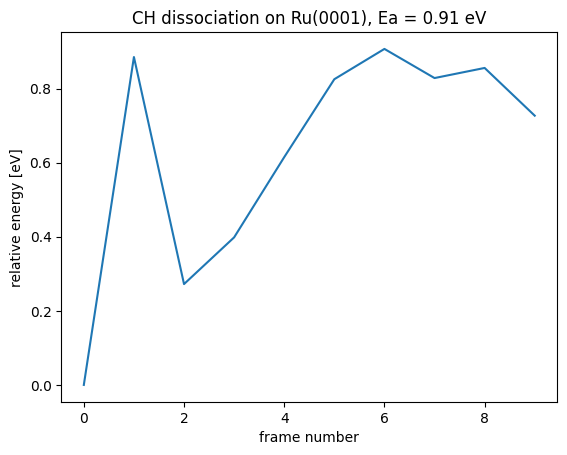

In [15]:
# Plot the reaction coordinate

es = [e - es[0] for e in es]
plt.plot(es)
plt.xlabel("frame number")
plt.ylabel("relative energy [eV]")
plt.title(f"CH dissociation on Ru(0001), Ea = {max(es):1.2f} eV")
plt.savefig("CH_dissoc_on_Ru_0001.png")

To generalize an interactive visualization, use `ase gui` from the command line or the X3D package

In [ ]:
# Make an interative html file of the optimized neb trajectory
x3d = X3D(optimized_neb)
x3d.write("optimized_neb_ch_disoc_on_Ru0001.html")